# Problem Set #3

## Exercise 2.1

In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
from matplotlib import pyplot as plt
import time

In [2]:
# Setting the parameters
A = 1                # productivity scale parameter
alpha = 0.35         # capital share of income
beta = 0.442         # 20-year discount factor
delta = 0.6415       # 20-year depreciation rate
sigma = 3            # relative risk aversion coefficient
labor = np.array([1, 1, 0.2])       # labor supply of three periods
SS_tol = 1e-9                       # error tolerance
f_params = (labor, A, alpha, delta) # input parameters

# equilibrium following market-clearing conditions
get_r = lambda K, L, alpha, delta, A : A * alpha * ((L / K) ** (1 - alpha)) - delta
get_w = lambda K, L, alpha, A: A * (1 - alpha) * ((K / L) ** alpha)

# Setting the functions
get_K = lambda b2, b3: b2 + b3
get_cons = lambda b_s, b_s_1, n_s, r, w: w * n_s + (1 + r) * b_s - b_s_1
get_util = lambda c, sigma=3: (c ** (1 - sigma))/(1 - sigma)
get_MU = lambda c, sigma=3: c ** (-sigma)
get_Y = lambda K, L, alpha, A: A * (K ** alpha) * (L ** (1-alpha))

In [3]:
def feasible(f_params, bvec_guess):
    
    labor, A, alpha, delta = f_params
    b2, b3 = bvec_guess
    K = get_K(b2, b3)
    L = np.sum(labor)
    r = get_r(K, L, alpha, delta, A)
    w = get_w(K, L, alpha, A)
    
    c1 = get_cons(0, b2, labor[0], r, w)
    c2 = get_cons(b2, b3, labor[1], r, w)
    c3 = get_cons(b3, 0, labor[2], r, w)
    
    # Initialize containers for boolean values
    b_cnstr = np.zeros(2, dtype = 'bool')
    c_cnstr = np.zeros(3, dtype = 'bool')
    K_cnstr = ((b2 + b3) <= 0)
    
    c_cnstr[0], c_cnstr[1], c_cnstr[2] = (c1 <= 0), (c2 <= 0), (c3 <= 0)
    
    if c_cnstr[0]:
        b_cnstr[0] = 1
    if c_cnstr[1]:
        b_cnstr[0], b_cnstr[1] = 1, 1
    if c_cnstr[2]:
        b_cnstr[1] = 1
        
    return b_cnstr, c_cnstr, K_cnstr

### 2.1.a

In [4]:
print('if violated? b_cnstr, c_cnstr, K_cnstr: ')
print(feasible(f_params, np.array([1.0, 1.2])))

if violated? b_cnstr, c_cnstr, K_cnstr: 
(array([ True, False]), array([ True, False, False]), False)


The constraints for period 1 are violated. 

### 2.1.b

In [5]:
print('if violated? b_cnstr, c_cnstr, K_cnstr: ')
print(feasible(f_params, np.array([0.06, -0.001])))

if violated? b_cnstr, c_cnstr, K_cnstr: 
(array([False, False]), array([False, False, False]), False)


No constraint is violated. 

### 2.1.c

In [6]:
print('if violated? b_cnstr, c_cnstr, K_cnstr: ')
print(feasible(f_params, np.array([0.1, 0.1])))

if violated? b_cnstr, c_cnstr, K_cnstr: 
(array([False, False]), array([False, False, False]), False)


No constraint is violated. 

## Exercise 2.2

In [7]:
var_dict = {
    'b_ss': 'savings', 
    'c_ss': 'consumptions', 
    'w_ss': 'wage', 
    'r_ss': 'interest rate', 
    'K_ss': 'capital', 
    'Y_ss': 'output', 
    'C_ss': 'Total consumption', 
    'EulErr_ss': 'Euler errors', 
    'RCerr_ss': 'resource constraint error', 
    'ss_time': 'task runtime'
}

def get_SS(params, bvec_guess, SS_graphs=False):
    
    def eul_eqs(bvec, f_params):
        labor, A, alpha, delta, beta = f_params
        b2, b3 = bvec
        L = labor.sum()
        K = get_K(b2, b3)
        r = get_r(K, L, alpha, delta, A)
        w = get_w(K, L, alpha, A)
        c1 = get_cons(0, b2, labor[0], r, w)
        c2 = get_cons(b2, b3, labor[1], r, w)
        c3 = get_cons(b3, 0, labor[2], r, w)
        MU1, MU2, MU3 = get_MU(c1), get_MU(c2), get_MU(c3)
        Eul1 = MU1 - beta * (1 + r) * MU2
        Eul2 = MU2 - beta * (1 + r) * MU3
        return np.array([Eul1, Eul2])
    
    start_time = time.perf_counter()
    beta, sigma, labor, L, A, alpha, delta, SS_tol = params
    f_params = np.array([labor, A, alpha, delta, beta])
    b_ss = optimize.root(eul_eqs, bvec_guess, args = (f_params)).x
    b2, b3 = b_ss
    K_ss = get_K(b2, b3)
    r_ss = get_r(K_ss, L, alpha, delta, A)
    Y_ss = get_Y(K_ss, L, alpha, A)
    w_ss = get_w(K_ss, L, alpha, A)
    c1 = get_cons(0, b2, labor[0], r_ss, w_ss)
    c2 = get_cons(b2, b3, labor[1], r_ss, w_ss)
    c3 = get_cons(b3, 0, labor[2], r_ss, w_ss)
    c_ss = np.array([c1, c2, c3])
    C_ss = c_ss.sum()
    EulErr_ss = eul_eqs(b_ss, f_params)
    RCerr_ss = Y_ss - C_ss - delta * K_ss
    ss_time = time.perf_counter() - start_time
    
    ss_output = {
    'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss,
    'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
    'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
    'ss_time': ss_time}
    
    if SS_graphs:
        fig, ax = plt.subplots()
        ax.plot(np.arange(1,4), c_ss, marker = 'o', label = 'consumptions')
        ax.plot(np.arange(2,4), b_ss, marker = 'o', label = 'savings')
        ax.legend()
        ax.set_title('Steady-state Distribution of Consumptions and Savings by Age')
        plt.show()
        
    return ss_output

### 2.2.a, b

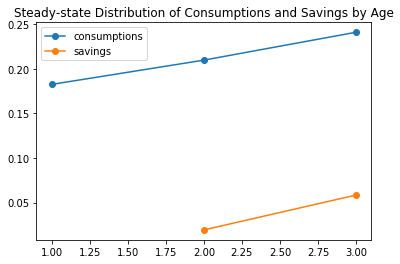

In [8]:
params = [beta, sigma, labor, labor.sum(), A, alpha, delta, SS_tol]
bvec_guess = np.array([0.1, 0.1])
ss_output = get_SS(params, bvec_guess, SS_graphs=True)

In [9]:
for key, value in ss_output.items(): 
    print(key, 
          ' ' * (9 - len(key)), 
          var_dict[key], 
          ' ' * (25 - len(var_dict[key])), 
          value)

b_ss       savings                    [0.01931253 0.0584111 ]
c_ss       consumptions               [0.18241213 0.20961468 0.24087387]
w_ss       wage                       0.20172465739052575
r_ss       interest rate              2.433062339127069
K_ss       capital                    0.07772362575316386
Y_ss       output                     0.6827603788602411
C_ss       Total consumption          0.6329006729395864
EulErr_ss  Euler errors               [-1.39266376e-12  2.62900812e-12]
RCerr_ss   resource constraint error  8.326672684688674e-17
ss_time    task runtime               0.0006485329999996736


### 2.2.c

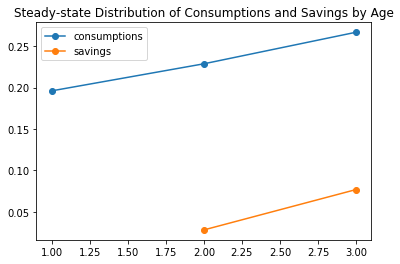

In [10]:
params2 = [0.55, sigma, labor, labor.sum(), A, alpha, delta, SS_tol]
ss_output2 = get_SS(params2, bvec_guess, SS_graphs=True)

In [11]:
for key, value in ss_output2.items(): 
    print(key, 
          ' ' * (9 - len(key)), 
          var_dict[key], 
          ' ' * (25 - len(var_dict[key])), 
          value)

b_ss       savings                    [0.02817692 0.07686545]
c_ss       consumptions               [0.19597528 0.22861594 0.26669307]
w_ss       wage                       0.22415219593446706
r_ss       interest rate              1.8863765057189819
K_ss       capital                    0.1050423702259807
Y_ss       output                     0.7586689708551193
C_ss       Total consumption          0.6912842903551526
EulErr_ss  Euler errors               [6.87805368e-12 2.52953214e-12]
RCerr_ss   resource constraint error  9.71445146547012e-17
ss_time    task runtime               0.00048596399999922824


If all households become more patient, that is, $\beta$ increases, wage $\bar{w}$, savings $\bar{b}$, and consumptions $\bar{c}$ increase, and the interest rate $\bar{r}$ decreases.

The intuition is that when the discount rate increase, people value the future more and the presence less, so that people save more for the future, which drives the interest rate to decrease to make the capital market clear. Then, firms rent more capital until the marginal productivity of capital equals the decreased interest rate. More capital increases marginal productivity of labor, which is by the assumption of the utility function and reasonable since more equipment helps workers produce more at the margin. This leads to higher wage and then, higher consumptions. 

## Exercise 2.3

In [12]:
def timepath(K_path_update, K_init, K_ss, T, A, alpha, delta, labor, m, Type):
    path = np.zeros([T + m, 4])
    period_path  = np.arange(1, T + m +1)
    if Type == "linear":
        K_path = np.linspace(K_init, K_ss, num = T)
    if Type == "update":
        K_path = K_path_update
    path[: , 0] = period_path
    path[: -m, 1] = K_path
    path[-m: , 1] = K_ss
    path[: , 2] = get_w(path[: , 1], labor.sum(), alpha, A)
    path[: , 3] = get_r(path[: , 1], labor.sum(), alpha, delta, A)
    return path

In [13]:
def EulErr(bvec, *args):
    w1, w2, w3, r2, r3, beta, alpha, delta, sigma, A, labor = args
    b2, b3 = bvec
    L = labor.sum()
    K = get_K(b2, b3)
    c1 = get_cons(0, b2, labor[0], r2, w1)
    c2 = get_cons(b2, b3, labor[1], r2, w2)
    c3 = get_cons(b3, 0, labor[2], r3, w3)
    MU1 = get_MU(c1)
    MU2 = get_MU(c2)
    MU3 = get_MU(c3)
    Eul1 = MU1 - beta*(1+r2) * MU2
    Eul2 = MU2 - beta*(1+r3) * MU3
    Euler_errs = np.array([Eul1, Eul2])
    return Euler_errs

In [14]:
def solve_path(path, *args):
    bvec_init_val, T, m, beta, alpha, delta, sigma, A, labor, bvec_ss = args
    b_mat = np.zeros([T + m, 3])
    b_mat[0, 0:-1] = bvec_init_val
    def get_b32(b32, *args):
        r2, r3, b21, w2, w3, beta, sigma, labor = args
        c2  = get_cons(b21, b32, labor[1], r2, w2)
        c3  = get_cons(b32, 0, labor[2], r3, w3)
        MU2 = get_MU(c2)
        MU3 = get_MU(c3)
        error =  MU2 - beta * (1 + r3) * MU3
        return error
    b32_init = 0.1
    b32_args  = (path[0 , 3], path[1 , 3], b_mat[0 , 0], path[0 , 2], path[1 , 2], beta, sigma, labor)
    b32 = optimize.root(get_b32, b32_init, args = (b32_args))
    b32 = b32.x
    b_mat[1 , 1] = b32
    for i in range(path.shape[0]-2):
        w1 = path[i - 1 , 2]
        w2 = path[i , 2]
        w3 = path[i + 1 , 2]
        r2 = path[i , 3]
        r3 = path[i + 1, 3]
        ts_args = (w1, w2, w3, r2, r3, beta, alpha, delta, sigma, A, labor)
        bvec_ts = optimize.root(EulErr, bvec_init, args = (ts_args))
        b_mat[i , 0] = bvec_ts.x[0]
        b_mat[i + 1, 1] = bvec_ts.x[1]
    b_mat[: , 2] = b_mat[: , 0] + b_mat[: , 1]
    return b_mat

In [15]:
def TPI(path_init, xival, tol, *args):
    bvec_init, T, m, beta, alpha, delta, sigma, A, labor, bvec_ss, K_ss = args
    b_mat = np.zeros([T + m, 3])
    b_mat[0, 0:-1] = bvec_init
    b_HH_init  = solve_path(path_init, bvec_init, T, m, beta, alpha, delta, sigma, A, labor, bvec_ss)
    diff_init = sum(((path_init[: -m, 1] - b_HH_init[: -m, 2])/path_init[: -m, 1])**2)
    if diff_init > tol:
        path = path_init
        b_HH = b_HH_init
        diff = diff_init
        iter_num = 0
        while diff > tol:
            update = xival * b_HH[: -m, 2] + (1 - xival) * path[: -m, 1]
            path = timepath(update, 0, K_ss, T, A, alpha, delta, labor, m, "update")
            b_HH = solve_path(path, bvec_init, T, m, beta, alpha, delta, sigma, A, labor, bvec_ss)
            diff = sum(((path[: -m, 1] - b_HH[: -m, 2])/path[: -m, 1])**2)
            iter_num = iter_num + 1
#             print("iteration: ", iter_num, "       difference: ", diff)

        result = (path, b_HH)
    else:
        result =  (path_init, b_HH_init)
    return result

In [16]:
xival = 0.2
tol = 1e-9
bvec_init = np.array([0.8 * ss_output['b_ss'][0], 1.1 * ss_output['b_ss'][1]])
T = 30
m = 25
bvec_ss = ss_output['b_ss']
K_ss = ss_output['K_ss']
K_init = bvec_init.sum()
path_init = timepath(0, K_init, K_ss, T, A, alpha, delta, labor, m, "linear")

In [17]:
### 2.3.a

In [18]:
path = TPI(path_init, xival, tol,  bvec_init, T, m, beta, alpha, delta, sigma, A, labor, bvec_ss, K_ss)

In [19]:
K_path = path[0][:, [0 , 1]]
w_path = path[0][:, [0 , 2]]
r_path = path[0][:, [0 , 3]]
b_path = path[1][:,:2]

In [20]:
Eulerr_path = np.zeros((30, 2))
RCerr_path = np.zeros(30)
for i in range(30):
    if i == 0:
        rt = rt1 = r_path[0,1]
        wt = wt1 = w_path[0,1]
        b2t = b2t1 = b_path[0, 0]
        b3t = b3t1 = b_path[0, 1]
    else:
        rt, rt1 = r_path[i, 1], r_path[i-1, 1]
        b2t, b3t = b_path[i,:]
        b2t1, b3t1 = b_path[i-1, :]
        wt, wt1 = w_path[i,1], w_path[i-1, 1]
    Kt = K_path[i,1]
    Kt_1 = K_path[i+1, 1]
    Yt = get_Y(Kt, labor.sum(), alpha, A)
    c1t = get_cons(0, b2t, labor[0], rt, wt)
    c2t = get_cons(b2t1, b3t, labor[1], rt1, wt)
    c3t = get_cons(b3t1, 0, labor[2], rt1, wt)
    Ct = c1t + c2t + c3t
    RCerr_path[i] = Yt - Ct - Kt_1 + (1 - delta) * Kt
    Eulerr_path[i, :] = EulErr(b_path[i, :], w_path[i,1], w_path[i+1,1], 
                               w_path[i+2,1], r_path[i+1,1], r_path[i+2,1], 
                               beta, alpha, delta, sigma, A, labor)

In [21]:
print('Maximum of the absolute values of all the Euler errors across the entire time path: ', 
      np.abs(Eulerr_path).max())
print('Maximum of the absolute values of all the resource constraint errors across the entire time path: ', 
      np.abs(RCerr_path).max())

Maximum of the absolute values of all the Euler errors across the entire time path:  37.40391904166589
Maximum of the absolute values of all the resource constraint errors across the entire time path:  0.005773427356908781


### 2.3.b

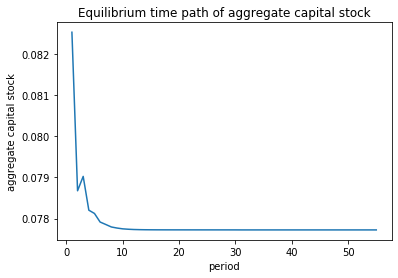

In [22]:
K_fig = plt.figure()
plt.plot(K_path[: , 0], K_path[: , 1])
plt.xlabel('period')
plt.ylabel('aggregate capital stock')
plt.title('Equilibrium time path of aggregate capital stock')
plt.show()

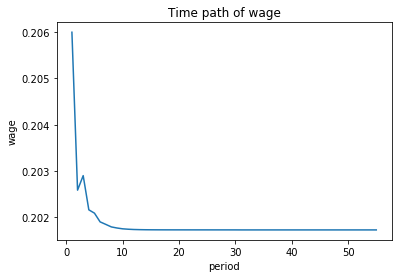

In [23]:
w_fig = plt.figure()
plt.plot(w_path[: , 0], w_path[: , 1])
plt.xlabel('period')
plt.ylabel('wage')
plt.title('Time path of wage')
plt.show()

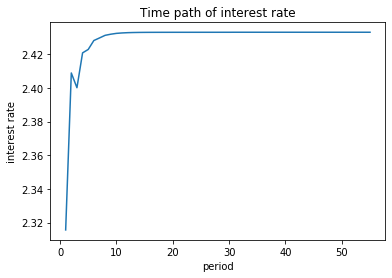

In [24]:
r_fig = plt.figure()
plt.plot(r_path[: , 0], r_path[: , 1])
plt.xlabel('period')
plt.ylabel('interest rate')
plt.title('Time path of interest rate')
plt.show()

### 2.3.c

In [25]:
for i in range(50):
    K = K_path[i, 1]
    if abs(K - K_ss) <= 1e-05:
        print('Number of periods until getting within 0.00001 of the steady-state aggregate capital stock: {} periods '.format(int(K_path[i, 0])))
        break

Number of periods until getting within 0.00001 of the steady-state aggregate capital stock: 12 periods 


In [26]:
for i in range(50):
    K_mat = K_path[i:, 1]
    Diff = np.abs(K_mat - K_ss)
    if np.sum(Diff > 1e-05) == 0:
        print(" After period {}, the aggregate capital stock never is again farther than 0.00001 away from the steady-state.".format(int(K_path[i, 0])))
        break

 After period 12, the aggregate capital stock never is again farther than 0.00001 away from the steady-state.
